# Topic Model on News Data

## Imports

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import spacy
import itertools
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
import warnings
import multiprocessing
import time
import re
from gensim.topic_coherence import direct_confirmation_measure
import logging
from nltk.stem import PorterStemmer
from scipy.stats import wilcoxon




sb.set_context('notebook')
warnings.simplefilter('ignore')


nlp = spacy.load('en_core_web_sm')

## Utils

In [ ]:
# Utils for Dataset Section

def clean(text, mode='lemma'):
        """ 
        Input:
            text(str): sentence to clean
        Output:
            cleaned_text(str): cleaned text
        Description: 
        Clean the text by keeping only content words followed by stemming and lowercasing.
        """
        if mode == 'lemma':
            cleaned_text = ' '.join([token.lemma_.lower() 
                                         for token in nlp(text)       
                                         if token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN'}])
        elif mode == 'stem':
            stemmer = PorterStemmer()
            cleaned_text = ' '.join([stemmer.stem(token.text.lower()) 
                                             for token in nlp(text)       
                                             if token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN'}])
        else:
            cleaned_text = ' '.join([token.text.lower() 
                                         for token in nlp(text)       
                                         if token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN'}])
        return cleaned_text
         

In [3]:
# Utils for Preliminary Topic Analysis 

def show_all_topics(X, vocab, n_topics, top_n_words):
    """  
    Input:
        X (np.array): matrix of shape (n_samples, n_words)
        vocab (np.array or list): list of words for each column of X
        n_topics (int): number of topics to extract
        top_n_words (int): number of words to show for each topic
    Output:
        Print the top_n words for each topic after applying SVD and NMF
    Description:
    This function applies SVD and NMF to the input matrix X and prints the top_n words for each topic.
    """

    def show_topics(M, vocab, top_n_words):
        """
        Input:
            M (np.array): matrix of shape (n_topics, n_words)
            vocab (np.array or list): list of words for each column of M
            top_n_words (int): number of words to show for each topic 
        Output:
            Print the top_n words for each topic
        """
        # Sort for importance in the Matrix and take top N
        topic_words = [[vocab[i] for i in np.argsort(word_vector)[:-top_n_words-1:-1]] for word_vector in M]

        # For better printing
        for k,t in enumerate(topic_words):
            h = ', '.join(t)
            print(f'{k+1}) {h}')

    #-------- SVD ---------
    print('-------SVD-------')
    svd = TruncatedSVD(n_components=n_topics, random_state=42)
    U = svd.fit_transform(X)
    S = svd.singular_values_
    VT = svd.components_
    print(f"U.shape {U.shape}, S.shape {np.diag(S).shape}, VT.shape {VT.shape}")
    # VT has a shape of (n_topics, n_words) from there we take the top_n words for each topic
    show_topics(VT, vocab, top_n_words)

    #-------- NMF -------- 
    print('--------NMF--------')
    nmf = NMF(n_components=n_topics, random_state=42)
    W = nmf.fit_transform(X) 
    H = nmf.components_
    print(f"W.shape {W.shape}, H.shape {H.shape}")
    # H has a shape of (n_topics, n_words) from there we take the top_n words for each topic
    show_topics(H, vocab, top_n_words)


def plot_topics_2d(X, labels = None):
    """
    Input:
        X (np.array): matrix of shape (n_samples, n_topics)
        labels (np.array or pd.Series): list of labels for each sample
    Output:
        Plot the 2D projection of the topics using SVD and NMF
    """
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    cm = plt.get_cmap('spring')

    def scatter_plot(ax, data, title):
        
        # Find unique labels
        n_labels = data['label'].nunique()

        # Assign colors based on color map
        label_colors = [cm(i / n_labels) for i in range(n_labels)]

        for idx, label in enumerate(data['label'].unique()):
            # Isolate subset of one label
            subset = data[data['label'] == label]
            # Plot the points with corresponding color
            ax.scatter(subset['x'], subset['y'],
                       color=label_colors[idx],
                       edgecolor='black',
                       alpha=0.6,
                       s=100)
        ax.set_title(title, fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(True)

    # SVD
    svd = TruncatedSVD(n_components=2, random_state=42)
    U = svd.fit_transform(X)
    df_svd = pd.DataFrame(U, columns=['x', 'y'])
    df_svd['label'] = labels if labels is not None else [''] * len(df_svd)
    # U has shape (n_doc x n_topics)
    scatter_plot(axes[0], df_svd, title="SVD projection")

    # NMF
    nmf = NMF(n_components=2, random_state=42)
    W = nmf.fit_transform(X)
    df_nmf = pd.DataFrame(W, columns=['x', 'y'])
    df_nmf['label'] = labels if labels is not None else [''] * len(df_nmf)
    # W has shape (n_doc x n_topics)
    scatter_plot(axes[1], df_nmf, title="NMF projection")

    plt.tight_layout()
    plt.show()

def plot_topics_3d(X, labels = None):
    """ 
    Input:
        X (np.array): matrix of shape (n_samples, n_topics)
        labels (np.array or pd.Series): list of labels for each sample
    Output:
        Plot the 3D projection of the topics using SVD and NMF
    """
    fig = plt.figure(figsize=(10, 10))
    axes = [fig.add_subplot(2, 1, 1, projection='3d'),
            fig.add_subplot(2, 1, 2, projection='3d')]
    cm = plt.get_cmap('spring')

    def scatter_plot(ax, data, title):

        # Find unique labels
        n_labels = data['label'].nunique()

        # Assign colors based on color map
        label_colors = [cm(i / n_labels) for i in range(n_labels)]

        for idx, label in enumerate(data['label'].unique()):
            # Isolate subset of one label
            subset = data[data['label'] == label]

            # Plot the points with corresponding color
            ax.scatter(subset['x'], subset['y'], subset['z'],
                       color=label_colors[idx],
                       edgecolor='black',
                       alpha=0.6,
                       s=60)
        ax.set_title(title, fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.grid(True)

    # SVD
    svd = TruncatedSVD(n_components=3, random_state=42)
    U = svd.fit_transform(X)
    df_svd = pd.DataFrame(U, columns=['x', 'y', 'z'])
    df_svd['label'] = labels if labels is not None else [''] * len(df_svd)
    # U has shape (n_doc x n_topics)
    scatter_plot(axes[0], df_svd, title="SVD projection (3D)")

    # NMF
    nmf = NMF(n_components=3, random_state=42)
    W = nmf.fit_transform(X)
    df_nmf = pd.DataFrame(W, columns=['x', 'y', 'z'])
    df_nmf['label'] = labels if labels is not None else [''] * len(df_nmf)
    # W has shape (n_doc x n_topics)
    scatter_plot(axes[1], df_nmf, title="NMF projection (3D)")

    plt.tight_layout()
    plt.show()


In [ ]:
# Utils for LDA Topic Modeling

# Function to compute coherence score also if there is a zero count on top topic words, it does that by adding ADD_VALUE
# to the count to prevent a division by zero error. We observed this, since CoherenceScore often return nan due to our
# lack of data.
# This is a custom log ratio measure for topic coherence, which is a modification of the original log ratio measure
# taken by https://github.com/piskvorky/gensim/issues/3040


                
log = logging.getLogger(__name__)

ADD_VALUE = 1
def custom_log_ratio_measure(segmented_topics, accumulator, normalize=False, with_std=False, with_support=False):
    """ 
    Input:
        segmented_topics (list): list of segmented topics
        accumulator (Accumulator): accumulator object containing word counts
        normalize (bool): whether to normalize the log ratio measure
        with_std (bool): whether to include standard deviation in the output
        with_support (bool): whether to include support in the output
    Output:
        topic_coherences (list): list of topic coherences for each segmented topic
    Description:
    This function computes the log ratio measure for topic coherence, which is a modification of the original log ratio measure.
    It takes into account zero counts by adding ADD_VALUE to it if the latter is true.
    """
    topic_coherences = []
    num_docs = float(accumulator.num_docs)
    for s_i in segmented_topics:
        segment_sims = []
        for w_prime, w_star in s_i:
            w_prime_count = accumulator[w_prime]
            w_star_count = accumulator[w_star]
            co_occur_count = accumulator[w_prime, w_star]

            if normalize:
                # For normalized log ratio measure
                numerator = custom_log_ratio_measure([[(w_prime, w_star)]], accumulator)[0]
                co_doc_prob = co_occur_count / num_docs
                m_lr_i = numerator / (-np.log(co_doc_prob + direct_confirmation_measure.EPSILON))
            else:
                # For log ratio measure without normalization
                ### _custom: Added the following 6 lines, to prevent a division by zero error.
                if w_star_count == 0:
                    log.info(f"w_star_count of {w_star} == 0. Adding {ADD_VALUE} to the count to prevent error. ")
                    w_star_count += ADD_VALUE
                if w_prime_count == 0:
                    log.info(f"w_prime_count of {w_prime} == 0. Adding {ADD_VALUE} to the count to prevent error. ")
                    w_prime_count += ADD_VALUE
                numerator = (co_occur_count / num_docs) + direct_confirmation_measure.EPSILON
                denominator = (w_prime_count / num_docs) * (w_star_count / num_docs)
                m_lr_i = np.log(numerator / denominator)

            segment_sims.append(m_lr_i)

        topic_coherences.append(direct_confirmation_measure.aggregate_segment_sims(segment_sims, with_std, with_support))

    return topic_coherences

direct_confirmation_measure.log_ratio_measure = custom_log_ratio_measure

# Function to print topics

def show_topics_lda(model, num_topics, num_words):
    """  
    Input:
        model (gensim.models.ldamulticore.LdaMulticore) : LDA model
        num_topics (int): number of topics to show
        num_words (int) : number of words to show for each topic
    Output:
        Print the top_n words for each topic
    """

    # Get the topic descriptions and get rid of formatting
    topic_sep = re.compile("0\.[0-9]{3}\*") 
    
    # Extract a list of tuples with topic number and descriptors from the model
    model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + '))
                    for topic_no, model_topic in
                    model.print_topics(num_topics=num_topics, num_words =num_words)]

    # Print the topics
    descriptors = []
    for i, m in model_topics:
        print(i+1, ", ".join(m[:5]))
        descriptors.append(", ".join(m[:2]).replace('"', ''))


# Function to grid search best LDA model
def evaluate_LDA(grid_LDA,dictionary,train_corpus, dev_texts, min_n_topics ,max_n_topics, random_state = 42, alpha = 0.75):
    """ 
    Input:
        grid_LDA (dictionary): grid to perform grid search
        dictionary (gensim.corpora.dictionary.Dictionary): dictionary with indeces as key and word as values
        train_corpus (list): tfidf gensim format list 
        dev_texts (list): list of texts different from the train corpus
        alpha (int [0,1]): parameter of convex combination
    Output:
        best_params (dictionary): dictionary with the best parameters
    Description:
    This function performs a grid search to find the best LDA model parameters based on:
         alpha*(Cv_score) + (1 -alpha)(U_mass_score)
    Where cv_score and u_mass_score were normalized between [0,1] to be comparable
    """

    # Keys refer to the possible parameters to iterate too
    keys = grid_LDA.keys()

    # Grid search, creating all possible combinations
    combinations = itertools.product(*grid_LDA.values())
    param_combinations = [dict(zip(keys, combo)) for combo in combinations]

    total_combinations = len(param_combinations)
    print(f"Testing {total_combinations} parameter combinations...")

    

    # keep track of the best    
    best_score = -float('inf')
    best_params = None
    num_topic = 0
    cv, u_mass = [],[]

    
    for i, params in enumerate(param_combinations):
        print(f"Testing combination {i+1}/{total_combinations}: {params}")   

        cv_scores, umass_scores = [], []
        for n_topics in range(min_n_topics,max_n_topics):
            try:
                
                # Model definition
                model = LdaMulticore(**params,
                                    corpus=train_corpus,
                                    id2word=dictionary,
                                    num_topics=n_topics,
                                    random_state=random_state
                                    )
                # Umass
                coherencemodel_umass = CoherenceModel(model=model,
                                              texts=dev_texts,
                                              dictionary=dictionary,
                                              coherence='u_mass')
                # Cv score
                coherencemodel_cv = CoherenceModel(model=model,
                                           texts=dev_texts,
                                           dictionary=dictionary,
                                           window_size = 25,
                                           coherence='c_v')

                cv_scores.append(coherencemodel_cv.get_coherence())
                umass_scores.append(coherencemodel_umass.get_coherence())

            except:
                continue
        # Scale Cv and Umass  in [0,1]
        scaler = MinMaxScaler()
        cv_scaled = scaler.fit_transform(np.array(cv_scores).reshape(-1, 1)).flatten()
        umass_scaled = scaler.fit_transform(np.array(umass_scores).reshape(-1, 1)).flatten()
        # Compute final score
        final_arr = alpha*cv_scaled +(1-alpha)*umass_scaled 
        # Return score of the method and tha number of topics
        score,topics  = np.max(final_arr), np.argmax(final_arr)

        if score > best_score:
            best_params = params
            num_topic = min_n_topics + topics
            cv, u_mass = cv_scores, umass_scores

            
    return best_params, num_topic, cv, u_mass


In [ ]:
# Utils for Coherence comparison 


def get_topic_words_from_matrix(model, feature_names, top_n_words=10):
    """ 
    Input:
      model(gensim.models.ldamulticore.LdaMulticore): gensim LdaMulticore pretrained model
      feature_names (np.array or list): list of words representing vocabulary
      top_n_words (int): number of words to return
    Output:
      List of top_n_words for each topic in the model
    """
    topic_words = []
    for topic_vec in model.components_:
        top_indices = topic_vec.argsort()[-top_n_words:][::-1]
        topic_words.append([feature_names[i] for i in top_indices])
    return topic_words

def compute_combined_coherence(topics, texts, dictionary):
    """ 
    Input:
      topics(list): list of lists composed of top words for each topic
      texts (list):lists of sentences in the corpus
      dictionary (gensim.corpora.dictionary.Dictionary): dictionary with indeces as key and word as values
    Output:
      Compute Cv scores and UMass scores given the topics and the text

    """
    # C_v
    cm_cv = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    score_cv = cm_cv.get_coherence()

    # UMass
    cm_umass = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='u_mass')
    score_umass = cm_umass.get_coherence()

    return score_cv, score_umass

## Dataset

In [5]:
# Dataset of Negative news on AI
df = pd.read_excel('dataset newspapers AI Final.xlsx', sheet_name='Sheet1')
df.head(10)

,ARTICLE,SENTENCES FROM ARTICLE
0,"AI means education as it is, not fit for purpo...",We drive children to be pale imitations of a c...
1,"AI means education as it is, not fit for purpo...",AI technology was advancing so quickly and bec...
2,"AI means education as it is, not fit for purpo...",Information will be targeted at each person's ...
3,Future of workers and AI; Robotics and artific...,The ILA's bigger concern is that automation be...
4,Future of workers and AI; Robotics and artific...,"Harold Daggett, the ILA's 78-year-old presiden..."
5,Future of workers and AI; Robotics and artific...,A Brookings Institution study says advanced ro...
6,Future of workers and AI; Robotics and artific...,It's understandable to fear that no matter wha...
7,America goes to war with AI: States across the...,States across the country are rushing to push ...
8,America goes to war with AI: States across the...,Lawmakers are feeling the heat after more than...
9,America goes to war with AI: States across the...,The celebrity-backed 'Disrupting the Deepfake ...


In [6]:
print('Number of documents:', len(df))
print('Number of nan:', df.isna().sum().sum())
print('Number of unique articles:', df['ARTICLE'].nunique())

Number of documents: 640
Number of nan: 0
Number of unique articles: 148


In [7]:
# Clean the extracted sentences
df['CLEANED SENTENCES'] = df['SENTENCES FROM ARTICLE'].apply(clean,mode = 'lemma')

# Check the length of the cleaned sentences
df['LENGTH'] = df['CLEANED SENTENCES'].apply(lambda x: len(x.split()))  

# See the length distribution
df.describe()


,LENGTH
count,640.000000
mean,16.967188
std,6.211745
min,4.000000
25%,12.750000
50%,16.000000
75%,21.000000
max,41.000000


## Preliminary Topic Analysis

In this part of the notebook I will employ Singular-Value-Decomposition (**TruncatedSVD**) and Negative-Matrix-Factorization (**NMF**) in order to understand the possible topics present in the corpus

In [8]:
# Join collocations and replace the original with collocated one

# Split the cleaned sentence for the function Phrases
cleaned_corpus = df['CLEANED SENTENCES'].apply(str.split).tolist()

# Join
phrases = Phrases(cleaned_corpus, min_count=5, threshold=0.5, scoring = 'npmi')
corpus_coll = phrases[cleaned_corpus]

# Undo the splitting after joining collocations
corpus_coll = [ ' '.join(doc) for doc in corpus_coll]

df['CLEANED SENTENCES'] = corpus_coll

# Free some memory
del corpus_coll, cleaned_corpus, phrases


In [9]:
tfidf = TfidfVectorizer(
                max_df=0.5,     # Remove words that appear in more than 50% of the documents
                min_df=2,       # Remove words that appear in less than 3 of the documents
                stop_words='english',
                use_idf=True,
                ngram_range=(1, 4)
            )
X = tfidf.fit_transform(df['CLEANED SENTENCES'])
print(f"Tfidf Matrix shape: {X.shape}")

Tfidf Matrix shape: (640, 2361)


In [10]:
# Show Topics 
n_topics = 10
top_n_words = 5
show_all_topics(X, tfidf.get_feature_names_out(), n_topics,top_n_words)

-------SVD-------


U.shape (640, 10), S.shape (10, 10), VT.shape (10, 2361)
1) use, artificial_intelligence, technology, say, people
2) job, human, concern, risk, technology
3) company, datum, work, train, openai
4) bias, woman, datum, generate, content
5) job, use, artificial_intelligence, tool, use artificial_intelligence
6) job, image, woman, year, say
7) human, risk, artificial_intelligence, machine, chatbot
8) generate, work, ai generate, human, say
9) tool, generative, generative ai, ai tool, increase
10) tool, say, ai tool, need, student
--------NMF--------
W.shape (640, 10), H.shape (10, 2361)
1) people, technology, make, ai technology, information
2) job, replace, year, say, lose
3) company, openai, chatbot, chatgpt, lawsuit
4) bias, datum, train, woman, gender
5) use, artificial_intelligence, use artificial_intelligence, voice, use ai
6) image, create, video, abuse, real
7) human, risk, machine, pose, control
8) generate, ai generate, content, work, generate content
9) concern, raise, potential

Given the variety of the articles took into consideration, these 10 topics depicted here, mainly the ones of **NMF** seems pretty understanding of the corpus and the taxonomy we previously analysed.

Now we will plot the reduced dimension version of the documents using both dimensionality reduction techniques. Since they all talk about AI fears  2,3 topics are very less to describe the complexity of the problem so we expect all the points to be very close to each other in both **SVD** and **NMF**

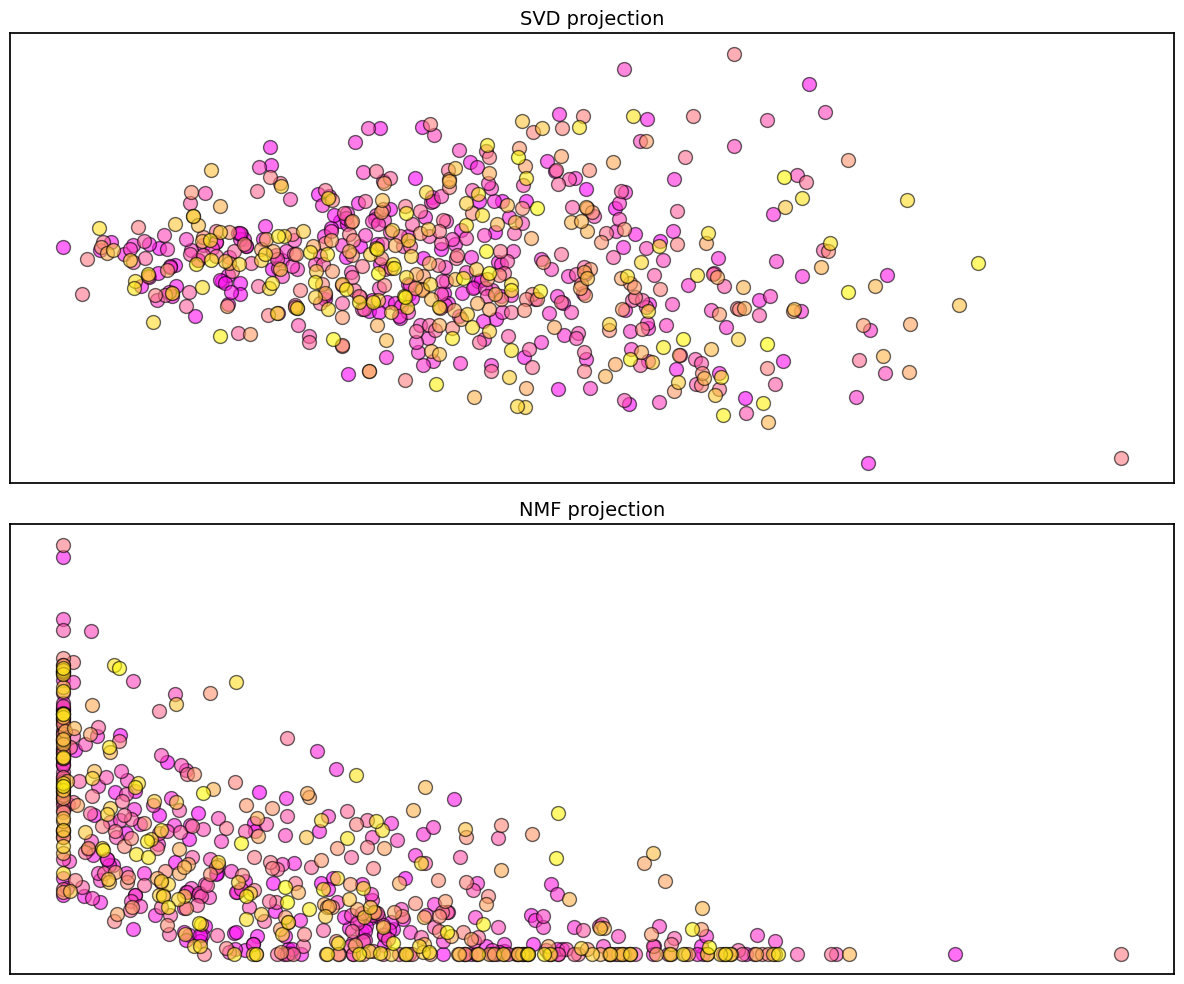

In [11]:
plot_topics_2d(X, labels = df['ARTICLE'])

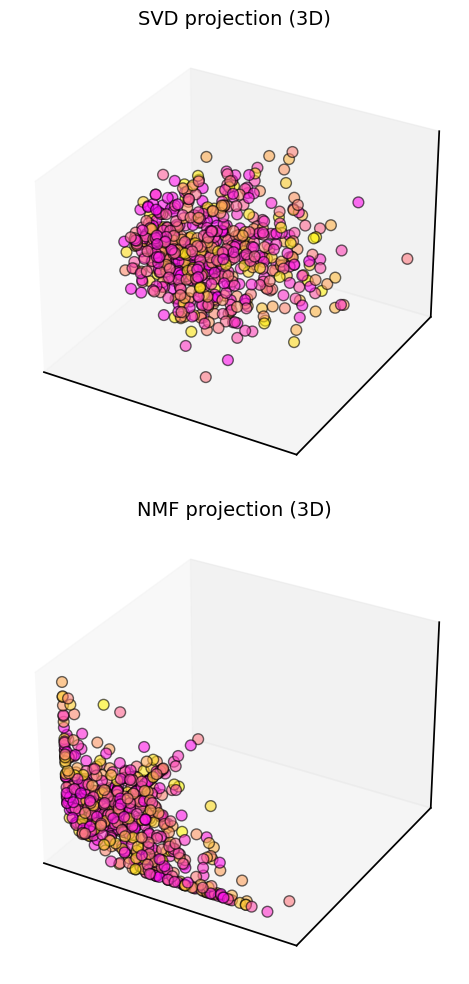

In [12]:
plot_topics_3d(X, labels = df['ARTICLE'])

## Latent Dirichlet Allocation

In [13]:
# Create the corpus of documents for the topic model
corpus = df['CLEANED SENTENCES'].apply(str.split).tolist()

# Join Collocations
phrases = Phrases(corpus, min_count=5, threshold=0.5, scoring = 'npmi')
corpus_coll = phrases[corpus]

# Create dictionary for topic model
dictionary = Dictionary(corpus_coll)

# Filter extremes
# Does not need to be in more that 50% of the documents
# and it needs to appear in at least 3 documents
dictionary.filter_extremes(no_below =2, no_above=len(df)*0.5) 

In [14]:
# Create Count matrix
ldacorpus = [dictionary.doc2bow(text) for text in corpus_coll]

# Transform it into tfidf count matrix
tfidfmodel = TfidfModel(ldacorpus)

# Extract the corpus
model_corpus = tfidfmodel[ldacorpus]

In [13]:
# Example
print(f"First sentence: {corpus_coll[0]}")
print(f'First BOW representation: {ldacorpus[0]}')
print(f'First TFIDF representation: {model_corpus[0]}')

First sentence: ['drive', 'child', 'pale', 'imitation', 'computer', 'say', 'daniele', 'harford', 'fox', 'speak', 'conference', 'focus', 'largely', 'role', 'artificial_intelligence', 'financial', 'service', 'industry', 'school', 'pupil', 'need', 'respond', 'change', 'drive', 'ai', 'say']
First BOW representation: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1)]
First TFIDF representation: [(0, 0.03470159864083819), (1, 0.09376841894434725), (2, 0.24352843161575544), (3, 0.18074044479805262), (4, 0.24352843161575544), (5, 0.27967652057536596), (6, 0.4870568632315109), (7, 0.22852561917024947), (8, 0.22852561917024947), (9, 0.19237753021063897), (10, 0.1993412816257318), (11, 0.24352843161575544), (12, 0.19574325724355857), (13, 0.24864716356622935), (14, 0.2530366227172737), (15, 0.24352843161575544), (16, 0.24352843161575544)]


In [ ]:
# Create a dev-set which has one document per article
dev_idx = df.groupby("ARTICLE", group_keys=False).apply(lambda x: x.sample(1)).index.tolist()

# Define the train-set as the remaining ones
train_idx = df[~df.index.isin(dev_idx)].index.tolist()

# Train in tfidf format
train_corpus = [model_corpus[i] for i in train_idx]

# Dev in text format
dev_texts = [corpus_coll[i] for i in dev_idx]


# Grid Search Training 

grid_LDA = {
    "alpha": {'symmetric','asymmetric', 0.1, 0.5},
    "eta": {'symmetric','auto', 0.1, 0.5},
    "passes": {1,5,10}
}

# Number of topics
min_n_topics = 3
max_n_topics = 15

# Extract best model and then choose best number of topics
best_params,num_topic, cv, u_mass = evaluate_LDA(grid_LDA,
                                                 dictionary,
                                                 train_corpus, 
                                                 dev_texts, 
                                                 min_n_topics = min_n_topics,
                                                 max_n_topics = max_n_topics,
                                                 random_state = 42)



Testing 48 parameter combinations...
Testing combination 1/48: {'alpha': 'asymmetric', 'eta': 0.5, 'passes': 1}
Testing combination 2/48: {'alpha': 'asymmetric', 'eta': 0.5, 'passes': 10}
Testing combination 3/48: {'alpha': 'asymmetric', 'eta': 0.5, 'passes': 5}
Testing combination 4/48: {'alpha': 'asymmetric', 'eta': 0.1, 'passes': 1}
Testing combination 5/48: {'alpha': 'asymmetric', 'eta': 0.1, 'passes': 10}
Testing combination 6/48: {'alpha': 'asymmetric', 'eta': 0.1, 'passes': 5}
Testing combination 7/48: {'alpha': 'asymmetric', 'eta': 'auto', 'passes': 1}
Testing combination 8/48: {'alpha': 'asymmetric', 'eta': 'auto', 'passes': 10}
Testing combination 9/48: {'alpha': 'asymmetric', 'eta': 'auto', 'passes': 5}
Testing combination 10/48: {'alpha': 'asymmetric', 'eta': 'symmetric', 'passes': 1}
Testing combination 11/48: {'alpha': 'asymmetric', 'eta': 'symmetric', 'passes': 10}
Testing combination 12/48: {'alpha': 'asymmetric', 'eta': 'symmetric', 'passes': 5}
Testing combination 13/

In [ ]:
print(f'Optimal grid: {best_params}')
print(f'Optimal number of topics: {num_topic}')
print(f'Optimal cv_score: {cv[num_topic - min_n_topics]}')
print(f'Optimal Umass_score: {u_mass[num_topic - min_n_topics]}')

Optimal grid: {'alpha': 'symmetric', 'eta': 'symmetric', 'passes': 5}
Optimal number of topics: 13
Optimal cv_score: 0.750713113594876
Optimal Umass_score: -16.27801652921856


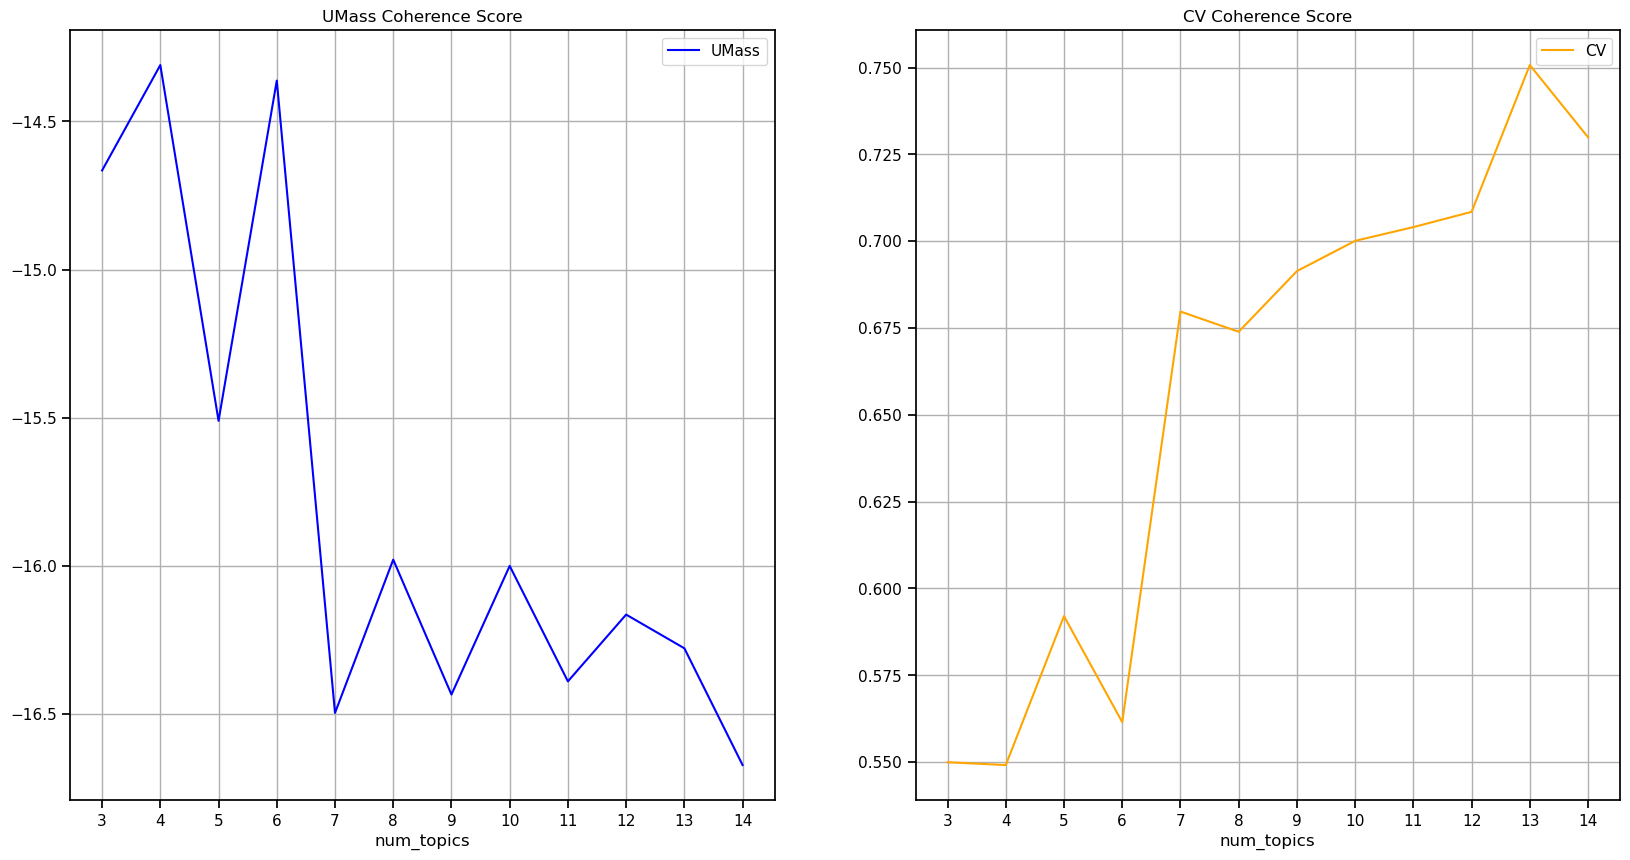

In [ ]:
coherence_values = [(i,j,k) for i,j,k in zip(range(min_n_topics,max_n_topics),u_mass,cv)]
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(min_n_topics,max_n_topics), color='blue',title = 'UMass Coherence Score',grid=True);
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(min_n_topics,max_n_topics), color= 'orange', title = 'CV Coherence Score',grid=True);

In [23]:
model = LdaMulticore(**best_params,
                     corpus=model_corpus,
                     id2word=dictionary,
                     num_topics=num_topic,
                     chunksize = len(model_corpus) * best_params["passes"]/200,
                     random_state=42
                    )

                     

In [ ]:
# Print the topics
show_topics_lda(model, num_topic, num_words=5)

1 "combine", "realistic", "violence", "success", "target"
2 "gender", "such", "artificial_intelligence", "openai", "use"
3 "regulate", "u.s.", "fake", "also", "too"
4 "keep", "benign", "exploit", "request", "designer"
5 "scale", "research", "world", "draw", "ghost"
6 "investor", "race", "computer", "time", "argue"
7 "fraud", "abuse", "fuel", "app", "war"
8 "ready", "much", "depression", "website", "medium"
9 "date", "million", "times", "york", "microsoft"
10 "bring", "quickly", "low", "publish", "effect"
11 "article", "disinformation", "thing", "falsely", "face"
12 "increase", "say", "adopt", "pose", "be"
13 "screenwriter", "celebrate", "copyright_infringement", "previously", "industrial"


## Coherence comparison

In this section we will understand which method between **SVD**, **NMF** and **LDA** gave the best results. In oder to do this, we will train all three methods in the whole corpus and compare them with the convex combination of Cv and Umass score. The number of topics chosen will be 10 which is the minimum number of topics obtained in LDA grid search between news and tweets.

In [ ]:
# Using the best parameters found in grid search
best_params = {'alpha': 'symmetric', 'eta': 'symmetric', 'passes': 5}

# Let us see how topics change taking 10 of them since in the news we got 10 as the optimal number of topics
num_topic = 10 

# LDA model
model = LdaMulticore(
    corpus=model_corpus,
    id2word=dictionary,
    num_topics=num_topic,
    alpha=best_params['alpha'],
    eta=best_params['eta'],
    passes=best_params['passes'],
    chunksize=int(len(model_corpus) * best_params["passes"] / 200),
    random_state=42
)

In [109]:
show_topics_lda(model, num_topic, num_words=5)

1 "percent", "llama", "negative", "infringe", "source"
2 "abuse", "unesco", "scammer", "advance", "point"
3 "world", "copyright", "content", "author", "humanity"
4 "chatgpt", "work", "screenwriter", "plagiarism", "u.s."
5 "date", "possibility", "forum", "specific", "fact"
6 "warn", "scam", "disinformation", "scale", "victim"
7 "fraud", "much", "gender", "issue", "internet"
8 "ai", "technology", "artificial_intelligence", "also", "use"
9 "gender_bias", "regulate", "fraudulent", "regulation", "few"
10 "low", "possible", "profit", "train", "discriminate"


In [110]:
# Compute topic word lists
n_topics = 10
alpha = 0.75

feature_names = tfidf.get_feature_names_out()
texts = [doc.split() for doc in df['CLEANED SENTENCES'].tolist()]


# Train NMF
nmf_model = NMF(n_components=n_topics, random_state=42)
nmf_model.fit(X)
nmf_topics = get_topic_words_from_matrix(nmf_model, feature_names)

# Train SVD
svd_model = TruncatedSVD(n_components=n_topics, random_state=42)
svd_model.fit(X)
svd_topics = get_topic_words_from_matrix(svd_model, feature_names)

# LDA already trained
lda_topics = [[word for word, _ in model.show_topic(i, topn=10)] for i in range(n_topics)]

# Compute raw (unnormalized) Cv and UMass scores
lda_cv, lda_umass = compute_combined_coherence(lda_topics, texts, dictionary)
nmf_cv, nmf_umass = compute_combined_coherence(nmf_topics, texts, dictionary)
svd_cv, svd_umass = compute_combined_coherence(svd_topics, texts, dictionary)

# Normalize scores across models (min-max)
cv_raw = np.array([lda_cv, nmf_cv, svd_cv]).reshape(-1, 1)
umass_raw = np.array([lda_umass, nmf_umass, svd_umass]).reshape(-1, 1)

scaler = MinMaxScaler()
cv_norm = scaler.fit_transform(cv_raw).flatten()
umass_norm = scaler.fit_transform(umass_raw).flatten()

# Convex combination (alpha = 0.75)
combined_scores = alpha * cv_norm + (1 - alpha) * umass_norm

# Print all scores
models = ['LDA', 'NMF', 'SVD']
for i, mod in enumerate(models):
    print(f"{mod}:")
    print(f"  Raw C_v:     {cv_raw[i][0]:.4f}")
    print(f"  Norm C_v:    {cv_norm[i]:.4f}")
    print(f"  Raw UMass:   {umass_raw[i][0]:.4f}")
    print(f"  Norm UMass:  {umass_norm[i]:.4f}")
    print(f"  Combined (normalized): {combined_scores[i]:.4f}")

LDA:
  Raw C_v:     0.4519
  Norm C_v:    0.6868
  Raw UMass:   -15.2307
  Norm UMass:  0.0000
  Combined (normalized): 0.5151
NMF:
  Raw C_v:     0.4861
  Norm C_v:    1.0000
  Raw UMass:   -6.2461
  Norm UMass:  0.9897
  Combined (normalized): 0.9974
SVD:
  Raw C_v:     0.3771
  Norm C_v:    0.0000
  Raw UMass:   -6.1526
  Norm UMass:  1.0000
  Combined (normalized): 0.2500


**NMF** seems definetly the best one, in order to make this hypotesis statistically significant we will perform a test. 

### Statistical test

Our desired test will be a paired **Wilcoxon signed-rank test**. We will test if **NMF** scores are significantly better than both **SVD** and **LDA**. To do this, we run 200 times all 3 models to get score observations for all the models. We will test singularly **NMF** vs **SVD** and **NMF** vs **LDA**.
For simplicity, let us call *X* the vector of scores from higher to lower (ranked) for **NMF** and *Y* the vector of scores for another model always ranked. Here the hypotesis are:\
$H_0$: *X_i* - *Y_i* symmetric around $\mu = 0$\
$H_1$: *X_i* - *Y_i* symmetric around $\mu > 0$\
This will tell us if the median of the vector of **NMF** scores is significantly higher than the rest.


In [ ]:
n_runs = 200
lda_scores, nmf_scores, svd_scores = [], [], []

#--NMF/SVD--
feature_names = tfidf.get_feature_names_out()
texts = [doc.split() for doc in df['CLEANED SENTENCES'].tolist()]
#--LDA--
best_params = {'alpha': 'symmetric', 'eta': 'symmetric', 'passes': 5}

#Inherent topic
alpha = 0.75
n_topics=10


for seed in range(n_runs):
    # Train models
    nmf_model_stat = NMF(n_components=n_topics, random_state=seed)
    svd_model_stat = TruncatedSVD(n_components=n_topics, random_state=seed)

    nmf_model_stat.fit(X)
    svd_model_stat.fit(X)

    nmf_topics_stat = get_topic_words_from_matrix(nmf_model_stat, feature_names)
    svd_topics_stat = get_topic_words_from_matrix(svd_model_stat, feature_names)

    lda_model_stat = model_LDA = LdaMulticore(
                                            corpus=model_corpus,
                                            id2word=dictionary,
                                            num_topics=n_topics,
                                            alpha=best_params['alpha'],
                                            eta=best_params['eta'],
                                            passes=best_params['passes'],
                                            chunksize=int(len(model_corpus) * best_params["passes"] / 200),
                                            random_state=seed
                                        )
    lda_topics_stat = [[word for word, _ in lda_model_stat.show_topic(i, topn=10)] for i in range(n_topics)]

    # Get raw scores
    lda_cv_stat, lda_umass_stat = compute_combined_coherence(lda_topics_stat, texts, dictionary)
    nmf_cv_stat, nmf_umass_stat = compute_combined_coherence(nmf_topics_stat, texts, dictionary)
    svd_cv_stat, svd_umass_stat = compute_combined_coherence(svd_topics_stat, texts, dictionary)

    # --- Normalize within run ---
    cv_raw_stat = np.array([lda_cv_stat, nmf_cv_stat, svd_cv_stat]).reshape(-1, 1)
    umass_raw_stat = np.array([lda_umass_stat, nmf_umass_stat, svd_umass_stat]).reshape(-1, 1)

    scaler = MinMaxScaler()
    cv_norm_stat = scaler.fit_transform(cv_raw_stat).flatten()
    umass_norm_stat = scaler.fit_transform(umass_raw_stat).flatten()

    combined_stat = alpha * cv_norm_stat + (1 - alpha) * umass_norm_stat

    lda_scores.append(combined_stat[0])
    nmf_scores.append(combined_stat[1])
    svd_scores.append(combined_stat[2])

In [ ]:
# Convert to numpy arrays
lda_scores = np.array(lda_scores)
nmf_scores = np.array(nmf_scores)
svd_scores = np.array(svd_scores)

# Wilcoxon 
# Wilcoxon test: NMF vs LDA (one-sided: is NMF > LDA?)
w_stat_nmf_lda, p_val_wilcox_nmf_lda = wilcoxon(nmf_scores, lda_scores, alternative='greater')

# Wilcoxon test: NMF vs SVD (one-sided: is NMF > SVD?)
w_stat_nmf_svd, p_val_wilcox_nmf_svd = wilcoxon(nmf_scores, svd_scores, alternative='greater')

print(f"Wilcoxon test (NMF > LDA): p = {p_val_wilcox_nmf_lda:.4f}")
print(f"Wilcoxon test (NMF > SVD): p = {p_val_wilcox_nmf_svd:.4f}")
print(f"Wilcoxon test (NMF > SVD): p = {p_val_wilcox_nmf_svd:.4f}")

Wilcoxon test (NMF > LDA): p = 0.0000
Wilcoxon test (NMF > SVD): p = 0.0000


We observe a p_value 0 for 200 repetitions, so we can assert **NMF** is significantly better then **LDA** and **SVD**.

# Manually Refine Topics from NMF

Let us try to go deeper in **NMF** topics by manually refining them. We will do that by manually exchanging output words in order to get an higher coherence score. This is justified because the Cv score is computed by a sliding window in the whole corpus, so we are not inserting bias by adding new unfound words.

In [ ]:
# Ths is the Cv score obtained with the same number of topics
coherence_nmf = CoherenceModel(topics=nmf_topics,
                               texts=texts,
                               dictionary = dictionary,
                               coherence='c_v').get_coherence()
print(f"Baseline C_v score for NMF:\n{coherence_nmf:.4f}")

Baseline C_v score for NMF:
0.4861


In [131]:
show_all_topics(X, tfidf.get_feature_names_out(), n_topics, top_n_words)

-------SVD-------
U.shape (640, 10), S.shape (10, 10), VT.shape (10, 2368)
1) use, artificial_intelligence, technology, say, people
2) job, human, concern, risk, technology
3) company, work, datum, openai, train
4) bias, woman, generate, ai generate, content
5) job, use, artificial_intelligence, tool, replace
6) image, job, woman, chatbot, people
7) human, risk, artificial_intelligence, machine, chatbot
8) generate, work, ai generate, human, say
9) tool, say, ai tool, need, political
10) generative, generative ai, tool, generate, increase
--------NMF--------
W.shape (640, 10), H.shape (10, 2368)
1) use, artificial_intelligence, use artificial_intelligence, use ai, artificial_intelligence ai
2) concern, raise, privacy, ethical, concern ai
3) company, openai, chatbot, chatgpt, lawsuit
4) bias, woman, datum, gender, train
5) job, replace, year, say, time
6) image, generate, create, ai generate, abuse
7) human, risk, machine, pose, control
8) people, technology, make, information, ai techn

In [ ]:
n_topics = 10
feature_names = tfidf.get_feature_names_out()
texts = [doc.split() for doc in df['CLEANED SENTENCES'].tolist()]

#  NMF Topics
nmf_model = NMF(n_components=n_topics, random_state=42)
nmf_model.fit(X)
nmf_topics = get_topic_words_from_matrix(nmf_model, feature_names)

In [ ]:
nmf_topics

[['use',
  'artificial_intelligence',
  'use artificial_intelligence',
  'use ai',
  'artificial_intelligence ai',
  'voice',
  'make',
  'regulate',
  'fraud',
  'criminal'],
 ['concern',
  'raise',
  'privacy',
  'ethical',
  'concern ai',
  'potential',
  'question',
  'ai raise',
  'raise ethical',
  'impact'],
 ['company',
  'openai',
  'chatbot',
  'chatgpt',
  'lawsuit',
  'work',
  'copyright',
  'allege',
  'author',
  'accuse'],
 ['bias',
  'woman',
  'datum',
  'gender',
  'train',
  'model',
  'algorithm',
  'perpetuate',
  'candidate',
  'female'],
 ['job',
  'replace',
  'year',
  'say',
  'time',
  'business',
  'creative',
  'lose',
  'future',
  'worker'],
 ['image',
  'generate',
  'create',
  'ai generate',
  'abuse',
  'video',
  'real',
  'tell',
  'child',
  'content'],
 ['human',
  'risk',
  'machine',
  'pose',
  'control',
  'fear',
  'intelligence',
  'lead',
  'weapon',
  'human intelligence'],
 ['people',
  'technology',
  'make',
  'information',
  'ai tech

Taking from this long list we can refine our topics manually

In [ ]:
refined_topics = [
    ["job", "replace", "lose work", "future", "worker"],                            # Topic: job / automation
    ["bias", "woman", "gender", "candidate", "female"],                             # Topic: gender / bias
    ["generative ai", "image", "video", "abuse", "child"],                          # Deepfake x abuse
    ["scam", "phishing attack", "criminal", "voice", "fake"],                       # Topic: deepfake x fraud
    ["risk", "fear", "control", "human intelligence", "negative consequence"],      # Topic: generic danger
    ["privacy", "ethical", "concern", "raise ethical", "information"]               # Topic: privacy
]


In [130]:
refined_coherence = CoherenceModel(
    topics=refined_topics,
    texts=[doc.split() for doc in df['CLEANED SENTENCES']],
    dictionary=dictionary,
    coherence='c_v'
).get_coherence()

print(f"Cv coherence for manually refined topics: {refined_coherence:.4f}")

Cv coherence for manually refined topics: 0.7480
